## Random Forest Implementation on scaled reduced dataset with PCA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data)

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [4]:
df_pca = pd.read_csv('../../DimensionalityReductionData/pca.csv')

Keep only the 'averageRating' column and join with PC1,PC2, ... PC18 from PCA (components)

In [5]:
df_scaled_copy = df_scaled[['averageRating']]
df_scaled = df_pca
df_scaled['averageRating'] = df_scaled_copy['averageRating']
del df_scaled_copy

In [6]:
df_scaled.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,averageRating
0,0.073496,0.581127,-0.306591,-0.458056,-0.326569,-0.432148,0.285284,0.120601,-0.382754,-0.220533,-0.173304,-0.237751,-0.278836,-0.255647,-0.126061,-0.138865,0.025244,-0.275903,1
1,-0.674232,0.297946,0.299652,-0.247368,0.350443,0.430246,-0.511015,0.180800,-0.014047,-0.185657,0.105798,-0.102234,-0.070109,0.002179,0.138295,0.010346,0.088212,0.026563,0
2,-0.602295,-0.213501,-0.367282,0.446712,-0.379628,0.201488,0.226710,0.332919,-0.030743,-0.052051,0.197735,-0.145173,0.140576,0.062989,-0.117784,0.002612,-0.020744,0.096351,1
3,-0.308130,-0.303248,-0.099318,-0.550675,0.147219,-0.608601,-0.045995,0.519164,0.094052,-0.122320,0.207885,-0.691366,-0.326278,-0.371787,-0.147163,0.056105,-0.315359,-0.211726,0
4,-0.548584,-0.107256,0.301375,-0.134301,-0.221954,-0.139591,-0.175504,-0.064892,0.043229,-0.271392,0.054528,-0.095603,-0.064297,0.011336,0.107454,-0.038404,0.111143,0.080739,0


Take sample for (initial) tests

In [7]:
#df_scaled_sample = df_scaled.sample(n=1000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [9]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=seed)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.7221852098600933
F1 score: [0.73388641 0.70940767]


## Grid Search CV - 1

In [11]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

model = RandomForestClassifier(random_state=seed)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
The parameters with the highest score:  {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [12]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                               params  mean_test_score
47  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.725031
70  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724198
46  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.724032
59  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723865
55  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723699
71  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723615
69  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723615
58  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723116
63  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723032
67  {'bootstrap': True, 'max_depth': 10, 'min_samp...         0.723032


Metrics for RF-PCA-GS-CV1:
Accuracy: 0.7348
Weighted F1: 0.7342
Weighted Precision: 0.7352
Weighted Recall: 0.7348
Macro-Averaged Precision: 0.7354
Macro-Averaged Recall: 0.7333
F1: [0.75202492 0.71510379]
Precision: [0.72974607 0.74109792]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.78      0.75      1556
     Class 1       0.74      0.69      0.72      1446

    accuracy                           0.73      3002
   macro avg       0.74      0.73      0.73      3002
weighted avg       0.74      0.73      0.73      3002

Confusion Matrix


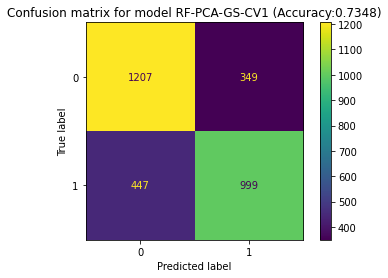

In [13]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('RF-PCA-GS-CV1', y_test, predictions)

In [14]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=seed, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))


Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7348434377081945
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7338441039307129
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.734510326449034
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7358427714856762
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.7361758827448368
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples

In [15]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [16]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.740506329113924
{'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [17]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = RandomForestClassifier(random_state=42, **params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.804414827155352
Parameters from place:  1   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.7990004164931279
Parameters from place:  2   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy for chosen parameters: 0.8036651395251978
Parameters from place:  3   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy for chosen parameters: 0.8014993752603082
Parameters from place:  4   {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy for chosen parameters: 0.8094960433152854
Parameters from place:  5   {'bootstrap': True, 'max_depth': 10, 'min_samples

In [18]:
accuracies=[]
max_depths=[]
for i in reversed(range(1,15)):
  model = RandomForestClassifier(random_state=seed, max_depth=i)
  model.fit(X_train, y_train)
  predictions = model.predict(X_train)
  accuracy = accuracy_score(y_train, predictions)
  max_depths.append(i)
  accuracies.append(accuracy)
  print("Accuracy for max depth :", i, " ", accuracy)

Accuracy for max depth : 14   0.9180341524364848
Accuracy for max depth : 13   0.8927113702623907
Accuracy for max depth : 12   0.8669720949604331
Accuracy for max depth : 11   0.8394002498958767
Accuracy for max depth : 10   0.8142440649729279
Accuracy for max depth : 9   0.792503123698459
Accuracy for max depth : 8   0.772844648063307
Accuracy for max depth : 7   0.7554352353186172
Accuracy for max depth : 6   0.7385256143273636
Accuracy for max depth : 5   0.7274468971261974
Accuracy for max depth : 4   0.7181174510620575
Accuracy for max depth : 3   0.7123698458975427
Accuracy for max depth : 2   0.7017909204498126
Accuracy for max depth : 1   0.6945439400249895


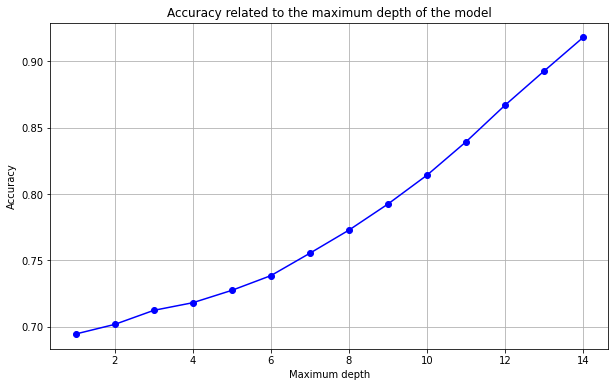

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, accuracies, marker='o', linestyle='-', color='b')

plt.title('Accuracy related to the maximum depth of the model')
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [20]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=random_state_fit)
  

  model = RandomForestClassifier(random_state=seed, **best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.7351765489673551
0.723850766155896
0.7358427714856762
0.7338441039307129
0.7311792138574283
0.7335109926715523
0.7335109926715523
0.7301798800799467
0.740506329113924
0.7188540972684877
0.7275149900066622
0.717854763491006
0.7191872085276483
0.7225183211192538
0.7395069953364424
0.7298467688207861
0.7215189873417721
0.7268487674883412
0.7335109926715523
0.7335109926715523
0.7388407728181212
0.7341772151898734
0.7281812125249834
0.7218520986009327
0.7311792138574283
0.7245169886742172
0.7285143237841439
0.7411725516322452
0.7251832111925383
0.7335109926715523
0.7428381079280479
0.72618254497002
0.7285143237841439
0.7281812125249834
0.7311792138574283
0.72618254497002
0.7328447701532311
0.7285143237841439
0.7201865423051299
0.7281812125249834
0.7311792138574283
0.7361758827448368
0.7225183211192538
0.7248500999333778
0.7331778814123917
0.7311792138574283
0.7435043304463691
0.7175216522318454
0.7465023317788141
0.7221852098600933
0.7395069953364424
0.7255163224516988
0.7321785476349101


Metrics for RF-PCA-Shuffled_best:
Accuracy: 0.7465
Weighted F1: 0.7460
Weighted Precision: 0.7476
Weighted Recall: 0.7465
Macro-Averaged Precision: 0.7478
Macro-Averaged Recall: 0.7460
F1: [0.75864256 0.73307611]
Precision: [0.73284314 0.76277372]
classification report
              precision    recall  f1-score   support

     Class 0       0.73      0.79      0.76      1521
     Class 1       0.76      0.71      0.73      1481

    accuracy                           0.75      3002
   macro avg       0.75      0.75      0.75      3002
weighted avg       0.75      0.75      0.75      3002

Confusion Matrix


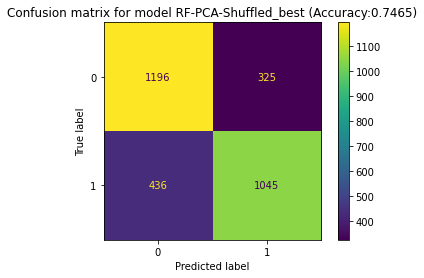

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
RF-PCA-Shuffled_best,0.746502,0.74603,0.747609,0.746502,0.747808,0.745965,[0.75864256 0.73307611],[0.73284314 0.76277372]


In [21]:
calculate_metrics('RF-PCA-Shuffled_best', y_best_predictions, best_predictions)